# beginning

In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data
from mne.preprocessing.peak_finder import peak_finder
from scipy.ndimage import measurements
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks_cwt
from scipy.stats import linregress
from pandas import get_dummies, read_csv
import matplotlib.gridspec as gridspec


%matplotlib inline

In [2]:
# helper functions

def download_data(data_file): 
    r = neo.AxonIO(filename=data_file)
    block = r.read_block()
    segment = block.segments[0]

    h1, drum = segment.analogsignals

    sampling_rate = float(h1.sampling_rate)
    drum = np.squeeze(np.array(drum)).astype(np.float64)
    h1 = np.squeeze(np.array(h1)).astype(np.float64)
    
    
    return h1, drum, sampling_rate


def find_oscillation_events(arr, direction, sfreq, h_freq=5, thresh=None):
    '''
    Idiosyncratic function designed to detect motion/null events in
    botfly oscillation-motion recordings. Roughly, works by:
        1. Filter: lowpass filters stimulus (drum) recording to smooth input signal.
        2. Peak finding: identify minima and maxima of drum signal.
        3. Events: Reorganize info as an [Nx3] array of [start, stop, condition], 
        where {CCW = 1, CW = 2}
           
   INPUTS
   -- arr: stimulus (drum) signal
   -- direction: CCW or CW
   -- sfreq: sampling frequency
   -- h_freq: lowpass frequency. If set to False, no lowpass applied.
    '''
    assert direction == 'CCW' or direction == 'CW'
    
    ## Filter data.
    if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)

    ## Identify extrema.
    maxima, _ = peak_finder(arr, thresh=thresh, extrema=1)
    minima, _ = peak_finder(arr, thresh=thresh, extrema=-1)

    ## Re-organize into events.
    events = np.sort(np.concatenate([maxima,minima]))
    events = np.array([events[i:i+2] for i in range(events.size-1)])
    if not events.size: raise ValueError('No events detected. Check paramaters.')

    ## Demarcate null/motion events.
    events = np.concatenate([events, np.zeros(events.shape[0], dtype=int).reshape(-1,1)], axis=-1)
    if direction == 'CCW':
        events[np.in1d(events[:,0], maxima), -1] = 1
        events[np.in1d(events[:,0], minima), -1] = 2
    else:
        events[np.in1d(events[:,0], maxima), -1] = 2
        events[np.in1d(events[:,0], minima), -1] = 1
        
    return events

def amplitude_thresholding(x0, thresh):
    '''Simple peak finding algorithm.'''
    assert x0.ndim == 1
    clusters, ix = measurements.label(x0 > thresh)
    peak_loc = np.concatenate(measurements.maximum_position(x0, labels=clusters, index=np.arange(ix)+1))
    peak_mag = measurements.maximum(x0, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag


def fix_events(events):
    events_copy = np.copy(events)
    for row_i, e in enumerate(events[:-1,:]):
        if events[row_i, 1] != events[row_i + 1, 0]:
            events_copy[row_i, 1] = events[row_i + 1, 0]
            
    return events_copy

data_file = 'data/17o23009.abf'
h1, drum, sampling_rate = download_data(data_file)
DEGREES_PER_VOLTAGE = 360 / (np.max(drum) - np.min(drum))

# first pass 

In [49]:
data_file = 'data/17o23000.abf'



h1_sample, drum_sample, sampling_rate = download_data(data_file)

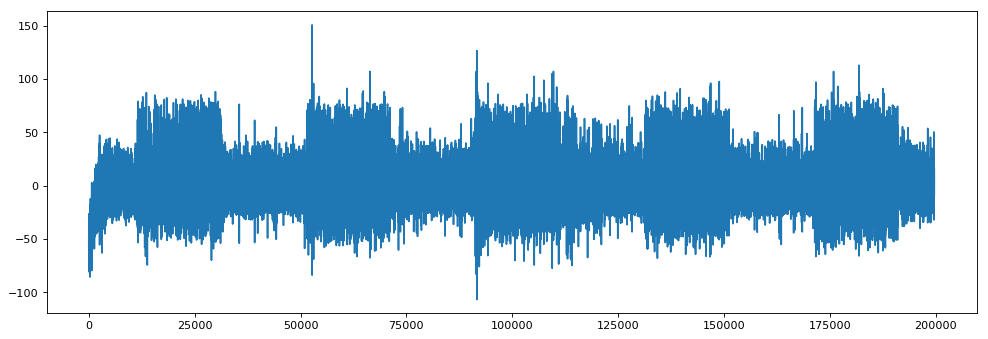

In [50]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(h1_sample)

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
direction = 'CCW' 
hfreq = 5.0
events_sample = find_oscillation_events(drum_sample, direction, sampling_rate, hfreq)
## Compute epoch lengths.
lengths_sample = np.diff(events_sample[:,:-1], axis=1) / sampling_rate


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-3-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


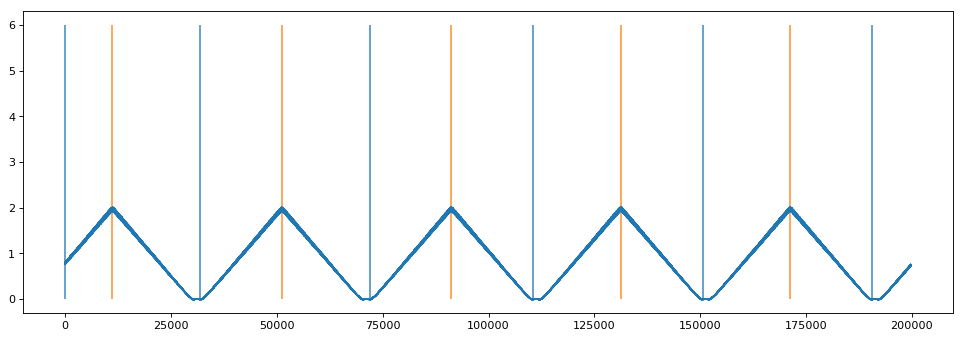

In [52]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(drum_sample)
ax = plt.gca()
## Add event markers.
for n, color in zip(np.unique(events_sample[:,-1]), ['#ff7f0e', '#1f77b4']):
    ax.vlines(np.arange(len(drum_sample))[events_sample[events_sample[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    


In [53]:
threshold = 55 # eyeballing the threshold
peak_loc, peak_mag = amplitude_thresholding(h1_sample, threshold)


In [54]:

    
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Epoching.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively count spikes within epoch.
data = []
df = []
for event in events_sample:

    ## Count spikes in window.
    n_spikes = np.logical_and( peak_loc >= event[0], peak_loc < event[1] ).sum()

    ## Append information.
    d = 'Stationary' if not event[-1] else 'CCW' if event[-1]==1 else 'CW'
    length = (event[1] - event[0]) / sampling_rate
    
    n_spike_rate = n_spikes / length
    data.append( [d, length, n_spikes, n_spike_rate] )

## Convert to DataFrame. Append.
data = pd.DataFrame(data, columns=('Direction','Duration','Spikes', 'Spike_rate'))
df.append(data)

df = pd.concat(df).reset_index(drop=True)
df.to_csv('spike_counts.csv', index=False)

    


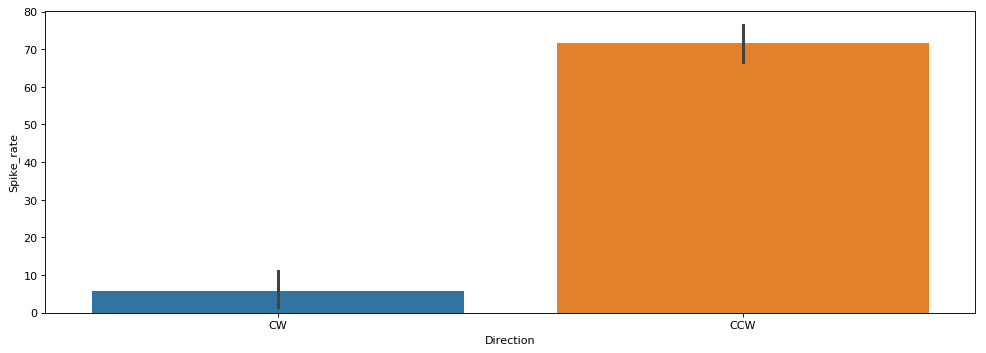

In [55]:
## Initialize canvas.
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')



## Plot difference in direction.
sns.barplot('Direction', 'Spike_rate', data=df)


# Varying Speed and Determining Avg Spike Count

fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


Done.


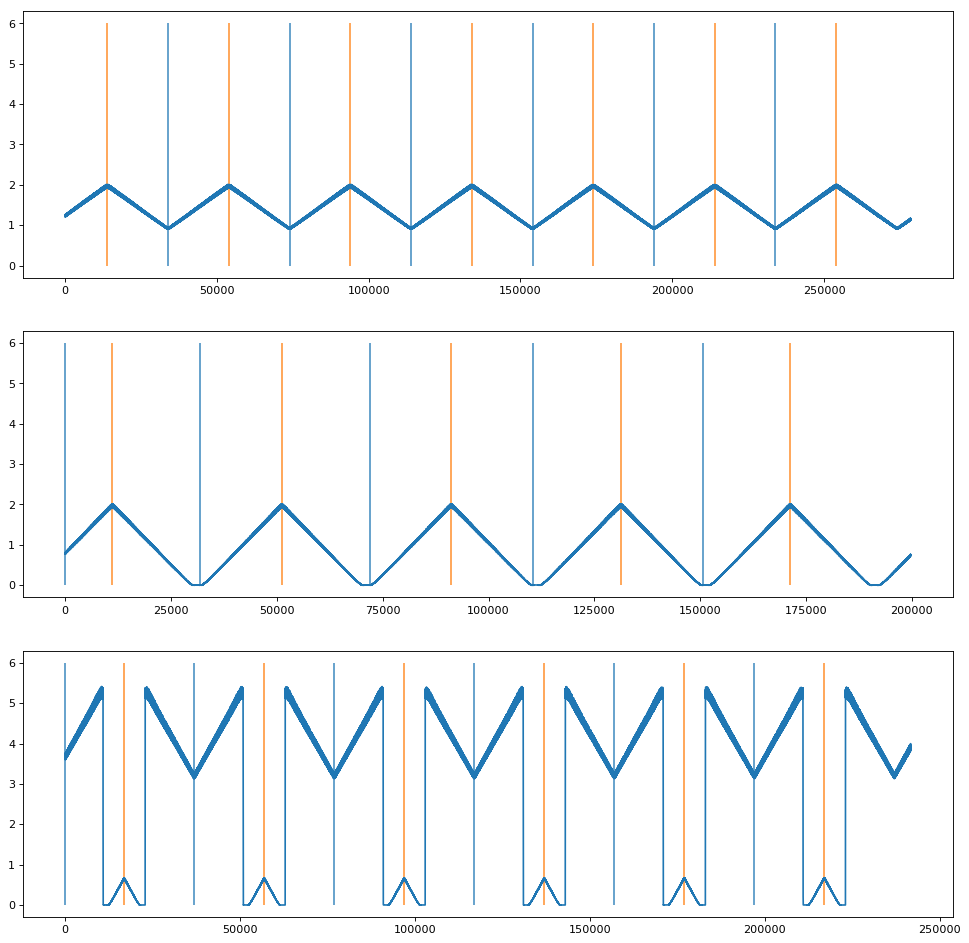

In [12]:
datafile_speed = ['data/17o23001.abf', 'data/17o23000.abf', 'data/17o23002.abf']
df = []
fig, ax = plt.subplots(3, 1, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
fix_offset = [-1, -1, 0]
for i, datafile in enumerate(datafile_speed):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Download Data
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    h1, drum, sampling_rate = download_data(datafile)

    ax[i].plot(drum)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    threshold = 55 # eyeballing the threshold
    peak_loc, peak_mag = amplitude_thresholding(h1, threshold)

    direction = 'CCW' 
    hfreq = 5.0
    events = find_oscillation_events(drum, direction, sampling_rate, hfreq, thresh = 1)
    ## Compute epoch lengths.
    lengths = np.diff(events[:,:-1], axis=1) / sampling_rate
    
    problem_areas = np.argwhere(lengths < 0.5)[:,0] 

    speed_all = []
    for row, event in enumerate(events):
        speed_all.append(linregress(np.arange(0, lengths[row], 1/sampling_rate), drum[event[0]: event[1]])[0])
    
    if fix_offset[i] > -1:
        events = np.delete(events, problem_areas, axis = 0)
        events = events[fix_offset[i]::2,:]
        
        speed_all = np.delete(speed_all, problem_areas, axis = 0)
        speed_all = speed_all[fix_offset[i]::2]
        
        events = fix_events(events)
        lengths = np.diff(events[:,:-1], axis=1) / sampling_rate

    
    speed = np.average(np.abs(speed_all)) * DEGREES_PER_VOLTAGE 
    for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
        ax[i].vlines(np.arange(len(drum))[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Epoching.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Iteratively count spikes within epoch.
    data = []
    
    for event in events:

        ## Count spikes in window.
        n_spikes = np.logical_and( peak_loc >= event[0], peak_loc < event[1] ).sum()


        ## Append information.
        d = 'Stationary' if not event[-1] else 'CCW' if event[-1]==1 else 'CW'
        length = (event[1] - event[0]) / sampling_rate
        
        n_spike_rate = n_spikes / length
        data.append( [speed, d, length, n_spikes, n_spike_rate] )
    ## Convert to DataFrame. Append.
    data = pd.DataFrame(data, columns=('Speed','Direction','Duration','Spikes', 'Spike_rate'))
    df.append(data)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Concatenate and save DataFrames.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Concatenate DataFrames.
df = pd.concat(df).reset_index(drop=True)
df.to_csv('spike_counts_speed.csv', index=False)

print('Done.')

In [77]:
df

,Speed,Direction,Duration,Spikes,Spike_rate
0,35.420010,CCW,2.0032,239,119.309105
1,35.420010,CW,2.0020,6,2.997003
2,35.420010,CCW,2.0008,230,114.954018
3,35.420010,CW,2.0006,6,2.999100
4,35.420010,CCW,2.0020,271,135.364635
5,35.420010,CW,1.9981,28,14.013313
6,35.420010,CCW,2.0011,226,112.937884
7,35.420010,CW,2.0021,4,1.997902
8,35.420010,CCW,2.0016,226,112.909672
9,35.420010,CW,2.0012,6,2.998201


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


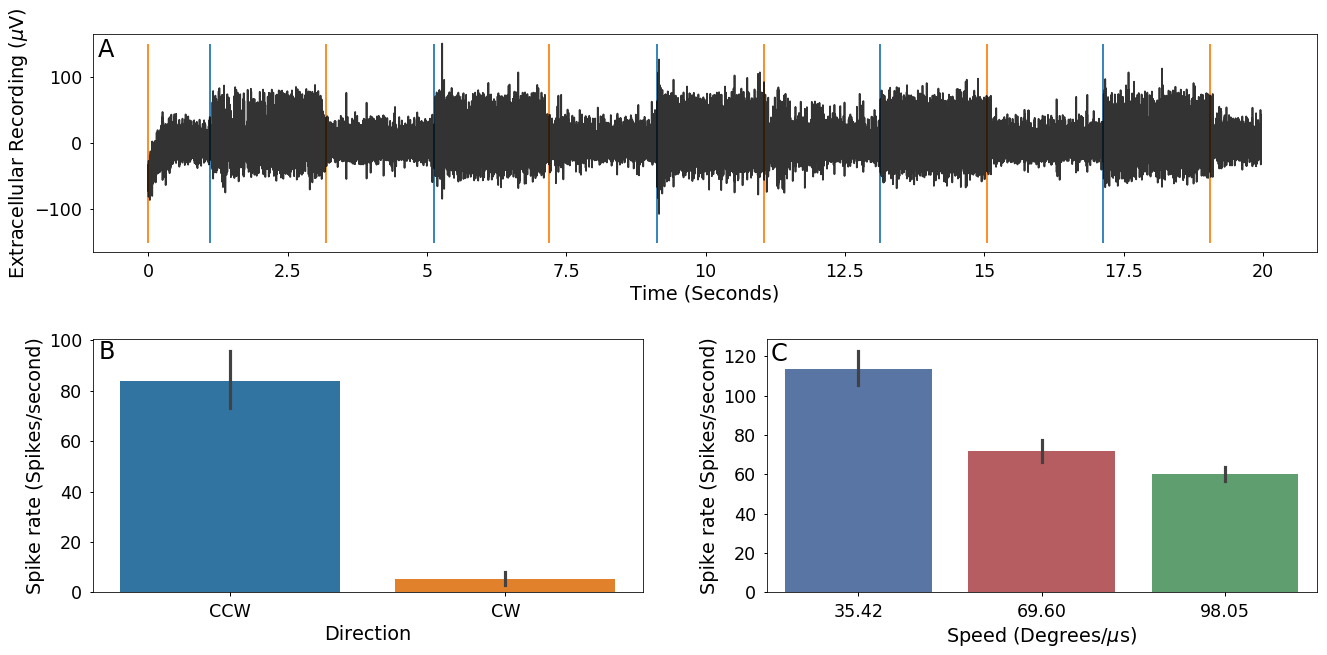

In [50]:
sns.set_context('notebook', font_scale=1.75)
 
## Open canvas for plotting.
fig = plt.figure(figsize=(20,8))

## Initialize top-half of plots.
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.125, right=0.975, bottom=0.6,  top=0.98, hspace=0.05)



ax = plt.subplot(gs[0])
ax.plot(h1_sample, color = 'k', alpha = 0.8)

plt.xticks(np.arange(0, len(h1_sample) + 25000, 25000), ['0', '2.5', '5','7.5',  '10', '12.5', '15', '17.5', '20'])
plt.xlabel('Time (Seconds)') 
plt.ylabel('Extracellular Recording ($\mu$V)')
## Add event markers.
for n, color in zip(np.unique(events_sample[:,-1]), ['#1f77b4', '#ff7f0e']):
    ax.vlines(np.arange(len(h1))[events_sample[events_sample[:,-1]==n, 0]], -150, 150, color=color)    

ax.legend()
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


## Initialize bottom-half of plots.
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.125, right=0.975, bottom=0.01, top=0.45, hspace=0.0, wspace=0.225)

## Plot difference in direction 
ax = plt.subplot(gs[0])
sns.barplot('Direction', 'Spike_rate', data=df)
plt.ylabel('Spike rate (Spikes/second)')
ax.text(-0.48, 100, 'B', va='top', ha='left', fontsize=24)
ax.text(-0.48, 220, 'A', va='top', ha='left', fontsize=24)




## Dummy-code Speed
_df = df.loc[df['Direction'] == 'CCW']
dummies = pd.get_dummies(_df.Speed)
_df = _df.merge(dummies, left_index=True, right_index=True)


## Plot difference in speed 
ax = plt.subplot(gs[1])
sns.barplot('Speed', 'Spike_rate', data=_df, palette=['#4c72b0', '#c44e52', '#55a868'])
plt.xticks(np.arange(3), ['35.42', '69.60', '98.05'])
plt.xlabel('Speed (Degrees/$\mu$s)')
plt.ylabel('Spike rate (Spikes/second)')
ax.text(-0.48, 127, 'C', va='top', ha='left', fontsize=24)


array([     0,  50000, 100000, 150000, 200000])

# Turning curves
##  Tuning Curves for changing bar length


In [4]:
data_file_width = 'data/17o23033.abf'
h1, drum, sampling_rate = download_data(data_file_width)

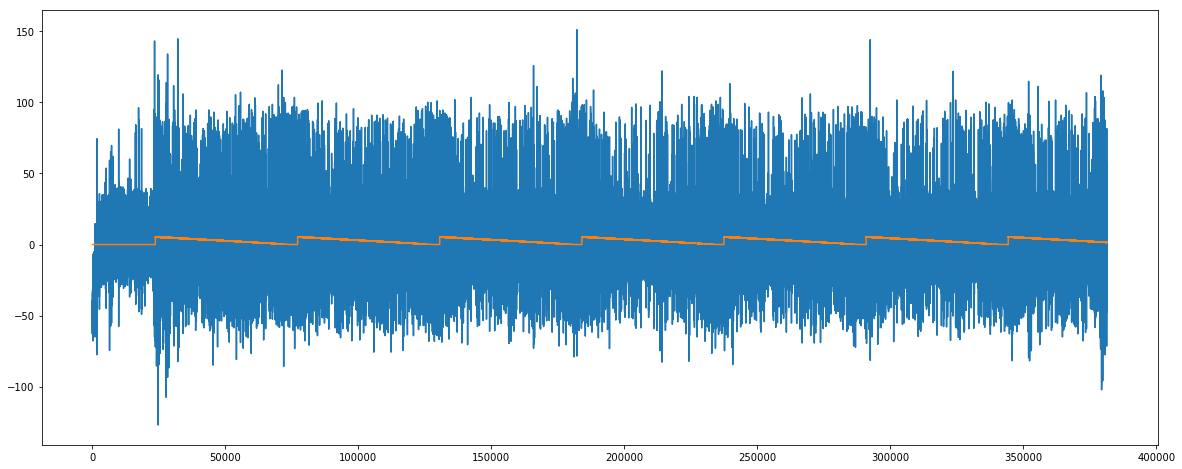

In [5]:
fig = plt.figure(figsize=(20,8))
plt.plot(h1)
plt.plot(drum)

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
direction = 'CCW' 
hfreq = 5.0
events = find_oscillation_events(drum, direction, sampling_rate, hfreq)
## Compute epoch lengths.

# get the CCW starts 
events = events[::2]
events = fix_events(events)
lengths = np.diff(events[:,:-1], axis=1) / sampling_rate


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-3-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


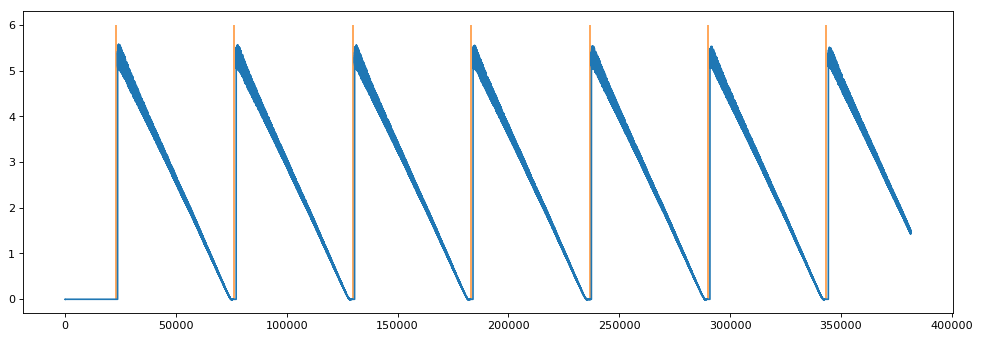

In [7]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(drum)
ax = plt.gca()
## Add event markers.
for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
    ax.vlines(np.arange(len(drum))[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    



In [8]:
## Bin size; take the minimum of the length (not including the last one because it's not a full cycle)
sample_size = int(min(lengths[:-1]) * sampling_rate) 
bar_length_spikes = np.zeros((len(lengths[:-1]), sample_size), float)
threshold = 55 # eyeballing the threshold

spike_count = np.zeros((sample_size, 1), int)
for event_i, event in enumerate(events[:-1,:]):
    ## Takes the spike_count in every event bucket 
    bar_length_spikes[event_i, :] = h1[event[0]: event[0] + sample_size]
    peak_loc, peak_mag = amplitude_thresholding(bar_length_spikes[event_i, :], threshold)
    spike_count[peak_loc] = spike_count[peak_loc] + 1 

In [77]:
num_bins = 50 
bin_size = int(sample_size / num_bins ) 

spike_rate_per_bin = np.zeros((int(num_bins * 0.80), 1), float)
for b in np.arange(int(num_bins * 0.80)): # take out last 20% 
    spike_rate_per_bin[b] = sum(spike_count[b * bin_size : (b + 1) * bin_size])/bin_size * sampling_rate

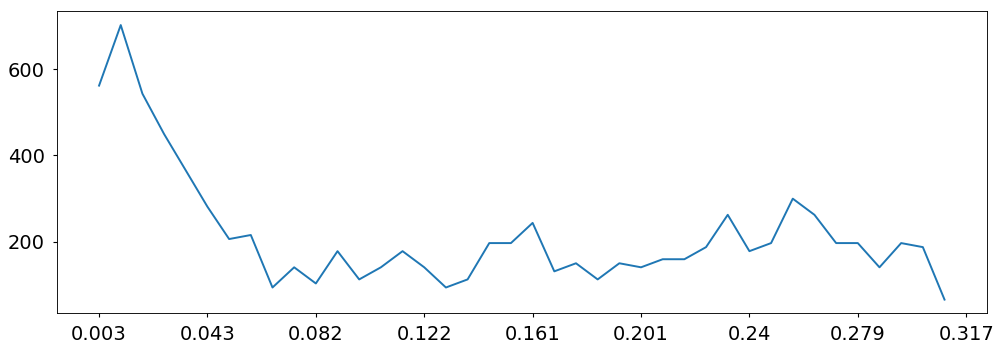

In [78]:

fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(spike_rate_per_bin)
# bar length ranges from 1.6 inches to 0.016 inches in forty bins 
receptive_field_angle = np.round(2 * np.arctan(np.arange(0.016, 1.6396, 0.0396)/10), 3).astype(str)

plt.xticks(np.arange(0, 41, 5), receptive_field_angle[::5]);



In [72]:
spike_rate_per_bin[:5]

array([[ 0.05617978],
       [ 0.07022472],
       [ 0.05430712],
       [ 0.04494382],
       [ 0.03651685]])

### first plot

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


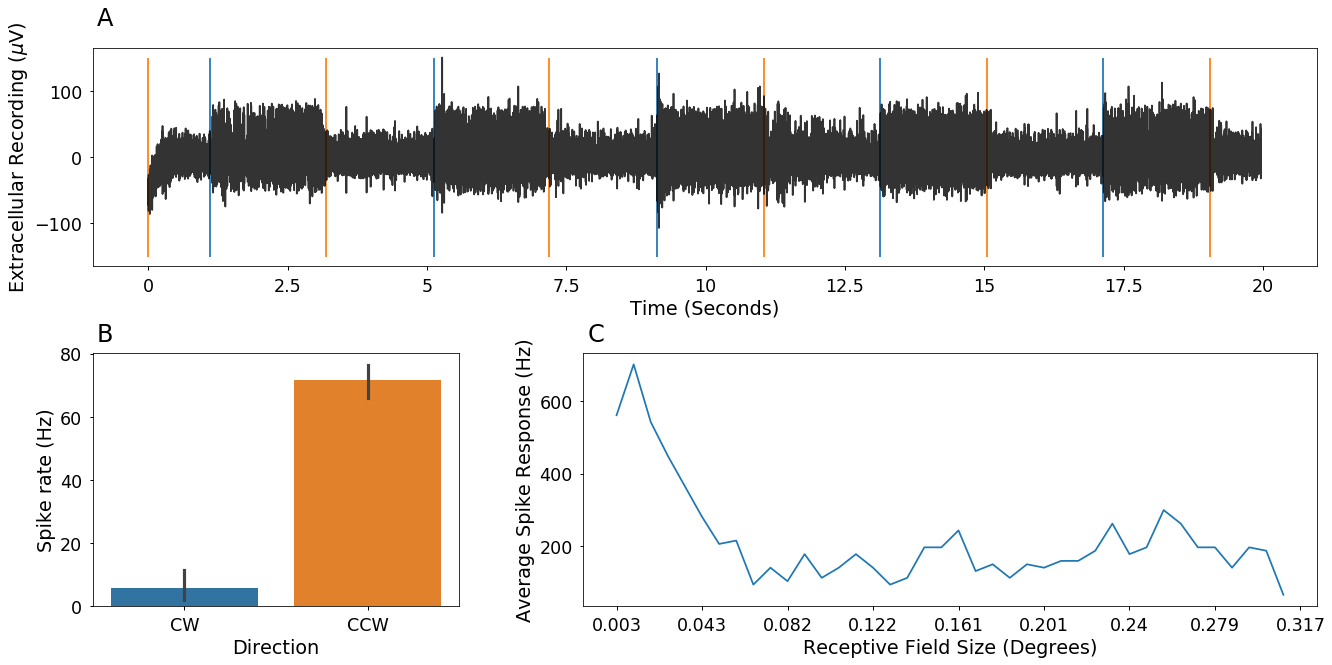

In [79]:
sns.set_context('notebook', font_scale=1.75)
 
## Open canvas for plotting.
fig = plt.figure(figsize=(20,8))

## Initialize top-half of plots.
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.125, right=0.975, bottom=0.6,  top=0.98, hspace=0.05)



ax = plt.subplot(gs[0])
ax.plot(h1_sample, color = 'k', alpha = 0.8)

plt.xticks(np.arange(0, len(h1_sample) + 25000, 25000), ['0', '2.5', '5','7.5',  '10', '12.5', '15', '17.5', '20'])
plt.xlabel('Time (Seconds)') 
plt.ylabel('Extracellular Recording ($\mu$V)')
## Add event markers.
for n, color in zip(np.unique(events_sample[:,-1]), ['#1f77b4', '#ff7f0e']):
    ax.vlines(np.arange(len(h1))[events_sample[events_sample[:,-1]==n, 0]], -150, 150, color=color)    

ax.legend()
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


## Initialize bottom-half of plots.
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2])
gs.update(left=0.125, right=0.975, bottom=0.01, top=0.45, hspace=0.0, wspace=0.225)

## Plot difference in direction 
ax = plt.subplot(gs[0])
sns.barplot('Direction', 'Spike_rate', data=df)
plt.ylabel('Spike rate (Hz)')
ax.text(-0.48, 90, 'B', va='top', ha='left', fontsize=24)
ax.text(-0.48, 190, 'A', va='top', ha='left', fontsize=24)
ax.text(2.2, 90, 'C', va='top', ha='left', fontsize=24)


ax = plt.subplot(gs[1])
plt.plot(spike_rate_per_bin)
# bar length ranges from 1.6 inches to 0.016 inches in forty bins 
receptive_field_angle = np.round(2 * np.arctan(np.arange(0.016, 1.6396, 0.0396)/10), 3).astype(str)

plt.xticks(np.arange(0, 41, 5), receptive_field_angle[::5]);
plt.xlabel('Receptive Field Size (Degrees)')
plt.ylabel('Average Spike Response (Hz)')

plt.savefig('first_fig.pdf')

## Turning Curve for changing contrast

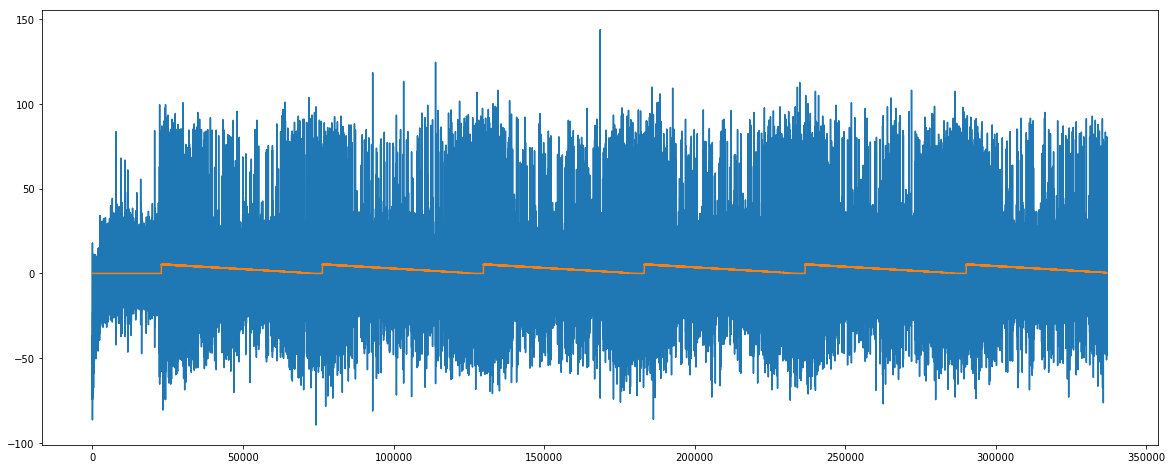

In [3]:
data_file_contrast = 'data/17o23034.abf'
h1, drum, sampling_rate = download_data(data_file_contrast)

fig = plt.figure(figsize=(20,8))
plt.plot(h1)
plt.plot(drum)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


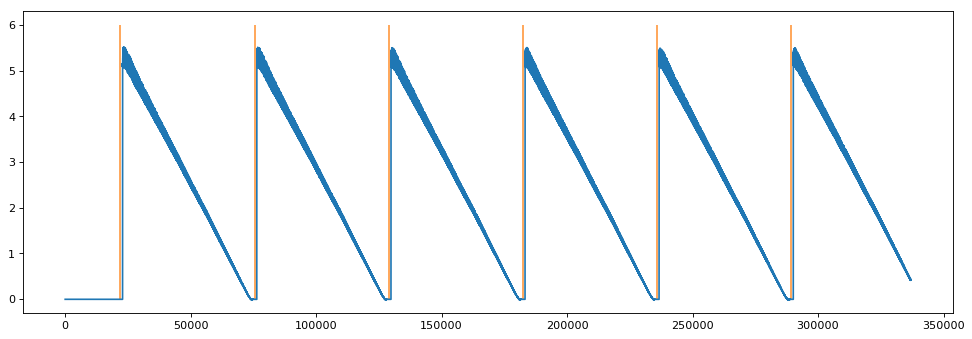

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
direction = 'CCW' 
hfreq = 5.0
events = find_oscillation_events(drum, direction, sampling_rate, hfreq)
## Compute epoch lengths.

# get the CCW starts 
events = events[::2]
events = fix_events(events)
lengths = np.diff(events[:,:-1], axis=1) / sampling_rate

fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(drum)
ax = plt.gca()
## Add event markers.
for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
    ax.vlines(np.arange(len(drum))[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    



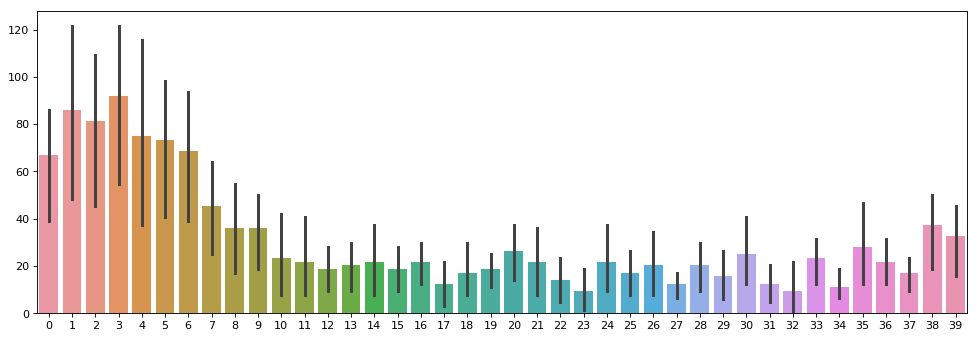

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Count Spikes Per Trial
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Bin size; take the minimum of the length (not including the last one because it's not a full cycle)
trial_size = int(min(lengths[:-1]) * sampling_rate) 
bar_length_spikes = np.zeros((len(lengths[:-1]), trial_size), float)
threshold = 55 # eyeballing the threshold

spike_count = np.zeros((events.shape[0], trial_size), int)
for event_i, event in enumerate(events[:-1,:]):


    ## Average spikes in the window 
    bar_length_spikes[event_i, :] = h1[event[0]: event[0] + trial_size]
    peak_loc, peak_mag = amplitude_thresholding(bar_length_spikes[event_i, :], threshold)

    spike_count[event_i, peak_loc] = 1 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike Rates in Bins
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
num_bins = 50 
bin_size = int(trial_size / num_bins ) 

spike_rate_per_bin_contrast = np.zeros((events.shape[0], int(num_bins * 0.80)), float)
for event_i, event in enumerate(events[:-1,:]):
    for b in np.arange(int(num_bins * 0.80)): # take out last 20% 
        spike_rate_per_bin_contrast[event_i, b] = sum(spike_count[event_i, b * bin_size : (b + 1) * bin_size])/bin_size * sampling_rate

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

sns.barplot(data=spike_rate_per_bin_contrast)

## Turning Curve for changing frequency

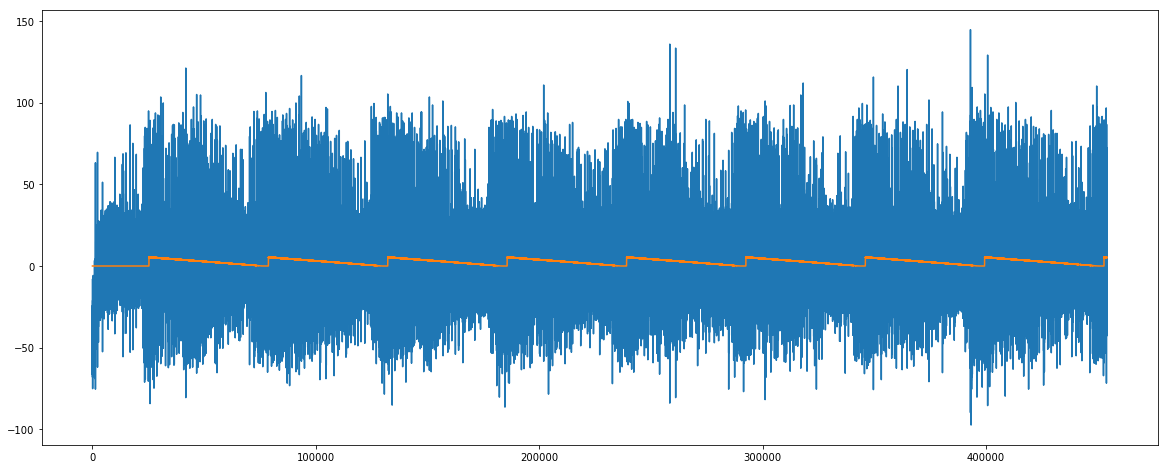

In [18]:
data_file_f = 'data/17o23035.abf'
h1, drum, sampling_rate = download_data(data_file_f)

fig = plt.figure(figsize=(20,8))
plt.plot(h1)
plt.plot(drum)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


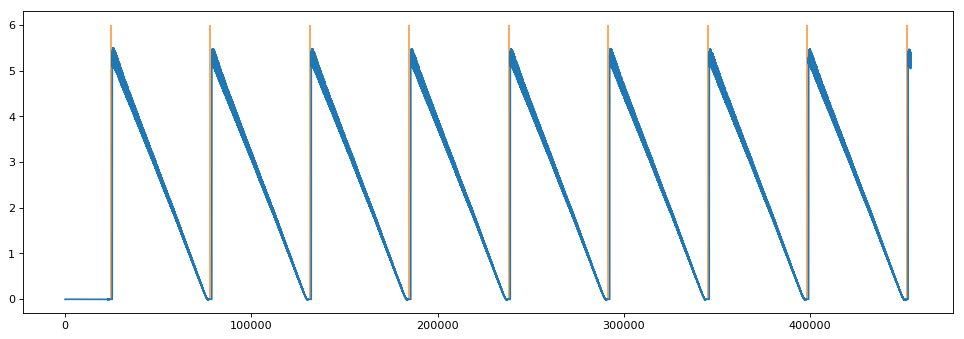

In [19]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
direction = 'CCW' 
hfreq = 5.0
events = find_oscillation_events(drum, direction, sampling_rate, hfreq)
## Compute epoch lengths.

# get the CCW starts 
events = events[::2]
events = fix_events(events)
lengths = np.diff(events[:,:-1], axis=1) / sampling_rate

fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(drum)
ax = plt.gca()
## Add event markers.
for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
    ax.vlines(np.arange(len(drum))[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    



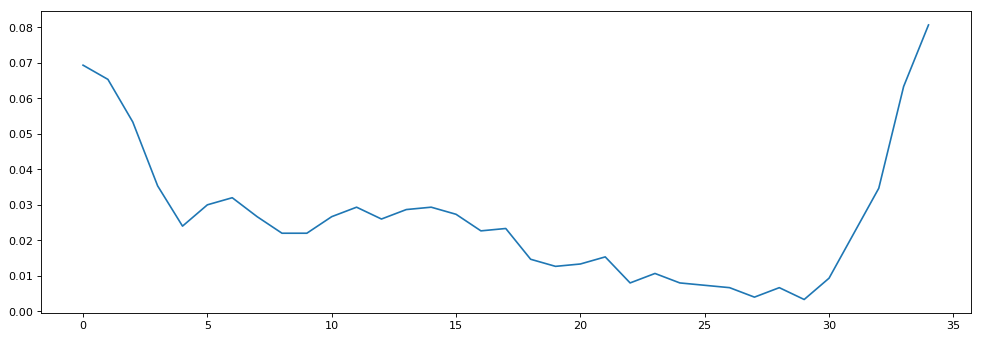

In [20]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Count Spikes Per Trial
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Bin size; take the minimum of the length (not including the last one because it's not a full cycle)
trial_size = int(min(lengths[:-1]) * sampling_rate) 
bar_length_spikes = np.zeros((len(lengths[:-1]), trial_size), float)
threshold = 55 # eyeballing the threshold

spike_count = np.zeros((trial_size, 1), int)
for event_i, event in enumerate(events[:-1,:]):


    ## Average spikes in the window 
    bar_length_spikes[event_i, :] = h1[event[0]: event[0] + trial_size]
    peak_loc, peak_mag = amplitude_thresholding(bar_length_spikes[event_i, :], threshold)
    spike_count[peak_loc] = spike_count[peak_loc] + 1 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike Rates in Bins
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

bin_size = 1500
num_bins = trial_size/1500

spike_rate_per_bin = np.zeros((int(num_bins), 1), float)
for b in np.arange(int(num_bins)):
    spike_rate_per_bin[b] = sum(spike_count[b * bin_size : (b + 1) * bin_size])/bin_size
    

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(spike_rate_per_bin)

## Varying Step Size (Time) 



fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-2-9293fb4dff84>:36: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  if h_freq: arr = filter_data(arr, sfreq, l_freq=None, h_freq=h_freq, phase='zero', verbose=False)


Done.


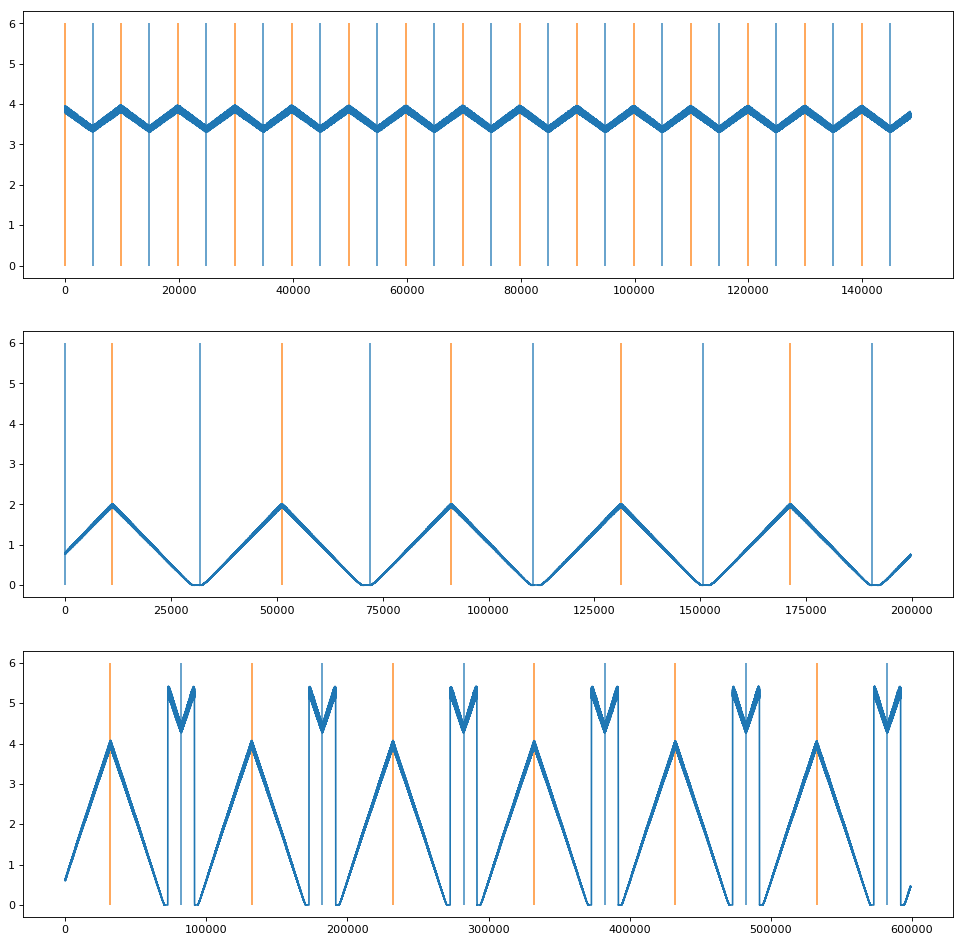

In [85]:
datafile_speed = ['data/17o23006.abf', 'data/17o23000.abf', 'data/17o23003.abf']
df = []
fig, ax = plt.subplots(3, 1, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
fix_offset = [-1, -1, 1]
step_size = [0.5, 2, 5]
for i, datafile in enumerate(datafile_speed):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Download Data
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    h1, drum, sampling_rate = download_data(datafile)

    ax[i].plot(drum)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Event detection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    threshold = 55 # eyeballing the threshold
    peak_loc, peak_mag = amplitude_thresholding(h1, threshold)

    direction = 'CCW' 
    hfreq = 5.0
    if fix_offset[i] > -1:
        events = find_oscillation_events(drum, direction, sampling_rate, hfreq, thresh = 1)
    else:
        events = find_oscillation_events(drum, direction, sampling_rate, hfreq)
 
    ## Compute epoch lengths.
    lengths = np.diff(events[:,:-1], axis=1) / sampling_rate
    
    problem_areas = np.argwhere(lengths < 0.5)[:,0] 

    speed_all = []
    for row, event in enumerate(events):
        speed_all.append(linregress(np.arange(0, lengths[row], 1/sampling_rate), drum[event[0]: event[1]])[0])
    
    if fix_offset[i] > -1:
        events = np.delete(events, problem_areas, axis = 0)
        events = events[fix_offset[i]::2,:]
        
        speed_all = np.delete(speed_all, problem_areas, axis = 0)
        speed_all = speed_all[fix_offset[i]::2]
        
        events = fix_events(events)
        lengths = np.diff(events[:,:-1], axis=1) / sampling_rate

    speed = np.average(np.abs(speed_all)) * DEGREES_PER_VOLTAGE 
    
    for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
        ax[i].vlines(np.arange(len(drum))[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Epoching.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Iteratively count spikes within epoch.
    data = []
    
    for event in events:

        ## Count spikes in window.
        n_spikes = np.logical_and( peak_loc >= event[0], peak_loc < event[1] ).sum()

        ## Append information.
        d = 'Stationary' if not event[-1] else 'CCW' if event[-1]==1 else 'CW'
        length = (event[1] - event[0]) / sampling_rate
        
        n_spike_rate = n_spikes / length
        data.append( [speed, d, length, n_spikes, step_size[i], n_spike_rate] )
    ## Convert to DataFrame. Append.
    data = pd.DataFrame(data, columns=('Speed','Direction','Duration','Spikes', 'Step_size', 'Spike_rate'))
    df.append(data)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Concatenate and save DataFrames.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Concatenate DataFrames.
df = pd.concat(df).reset_index(drop=True)
df.to_csv('spike_counts_speed.csv', index=False)

print('Done.')

In [86]:
df

,Speed,Direction,Duration,Spikes,Step_size,Spike_rate
0,67.100726,CCW,0.4804,34,0.5,70.774355
1,67.100726,CW,0.4949,3,0.5,6.061831
2,67.100726,CCW,0.5039,53,0.5,105.179599
3,67.100726,CW,0.4985,3,0.5,6.018054
4,67.100726,CCW,0.5034,50,0.5,99.324593
5,67.100726,CW,0.4991,0,0.5,0.000000
6,67.100726,CCW,0.5019,45,0.5,89.659295
7,67.100726,CW,0.4991,0,0.5,0.000000
8,67.100726,CCW,0.5006,42,0.5,83.899321
9,67.100726,CW,0.4969,3,0.5,6.037432


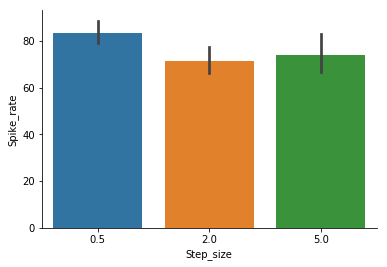

In [87]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#



## Dummy-code direction.
_df = df.loc[df['Direction'] == 'CCW']
dummies = pd.get_dummies(_df.Step_size)
df = df.merge(dummies, left_index=True, right_index=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


## Plot difference in direction.
sns.barplot('Step_size', 'Spike_rate', data=_df)
sns.despine()

In [114]:
def fix_drum_data(data, events_raw, length_raw):
    
    _data = np.copy(data)
    problem_areas = np.argwhere(length_raw < 0.5)[:,0] + 1
    
    if np.mod(len(problem_areas), 2) == 0:
        problem_areas = np.reshape(problem_areas, (int(len(problem_areas)/2), 2))

    else:
        import pdb; pdb.set_trace()
    for problem_area in (problem_areas):
        import pdb; pdb.set_trace()
        last_value = events[problem_area[0], 0]
        time_start = events[problem_area[0], 1]
        time_end = events[problem_area[1], 1]
        
        if data[last_value] > data[time_start]:
            _data[time_start:time_end] = data[time_start:time_end] + data[last_value]
        else:
            _data[time_start:time_end] = data[time_start:time_end] - data[last_value]

    return _data
            